In [81]:
import datetime
from calendar_ipynb.google_oauth import verify_credentials
from calendar_ipynb.events import fetch_events, filter_out_future_events, sort_events, handle_overlapping_event_durations, insert_untracked_times, insert_sleep_events, get_primary_timezone
from calendar_ipynb.ipywidgets.calendar_selection import (
    select_calendars,
    get_selected_calendars,
)
from calendar_ipynb.ipywidgets.date_range_selection import get_selected_date_range
from calendar_ipynb.meta import classify_events

%matplotlib widget
%load_ext autoreload
# Automatically reload all modules
%autoreload 2

EMAIL_IDS = ["fahimalizain@gmail.com", "fahim.zain@kwalee.com"]

for email in EMAIL_IDS:
    verify_credentials(email)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO:calendar_ipynb.google_oauth:Saving credentials to /home/fahimalizain/projects/calendar-ipynb/temp/fahimalizain@gmail.com-google-token.pickle
INFO:calendar_ipynb.google_oauth:✅ Credentials found for fahimalizain@gmail.com
INFO:calendar_ipynb.google_oauth:Saving credentials to /home/fahimalizain/projects/calendar-ipynb/temp/fahim.zain@kwalee.com-google-token.pickle
INFO:calendar_ipynb.google_oauth:✅ Credentials found for fahim.zain@kwalee.com


In [82]:
select_calendars(EMAIL_IDS)
selected_calendars = get_selected_calendars()
if not selected_calendars:
    raise ValueError("No calendars selected")

primary_timezone = get_primary_timezone(selected_calendars=selected_calendars)

INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


In [83]:
from_date, to_date = get_selected_date_range(timezone=primary_timezone)
if not from_date or not to_date:
    raise ValueError("Please provide from_date and to_date")

print("Date Range:", from_date, " TO ", to_date, 'in Timezone:', primary_timezone)

Date Range: 2025-02-12 00:00:00+05:30  TO  2025-03-14 23:59:59+05:30 in Timezone: Asia/Kolkata


In [84]:
events = []
for email, calendars in get_selected_calendars().items():
    for calendar in calendars:
        events.extend(
            fetch_events(
                email=email,
                calendar_id=calendar,
                from_datetime=from_date,
                to_datetime=to_date,
            )
        )
events = filter_out_future_events(events)
events = sort_events(events)
events = handle_overlapping_event_durations(events)
events = insert_sleep_events(events)
events = insert_untracked_times(events)
events = classify_events(events)

INFO:calendar_ipynb.events:Fetching events from 2025-02-12 00:00:00+05:30 to 2025-03-14 23:59:59+05:30 for fahimalizain@gmail.com
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events:Fetching events from 2025-02-12 00:00:00+05:30 to 2025-03-14 23:59:59+05:30 for fahimalizain@gmail.com
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events:Fetching events from 2025-02-12 00:00:00+05:30 to 2025-03-14 23:59:59+05:30 for fahimalizain@gmail.com
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events:Fetching events from 2025-02-12 00:00:00+05:30 to 2025-03-14 23:59:59+05:30 for fahimalizain@gmail.com
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events:Fetching events from 2025-02-12 00:00:00+05:30 to 2025-03-14 23:59:59+05:30 for fahim.zain@kw

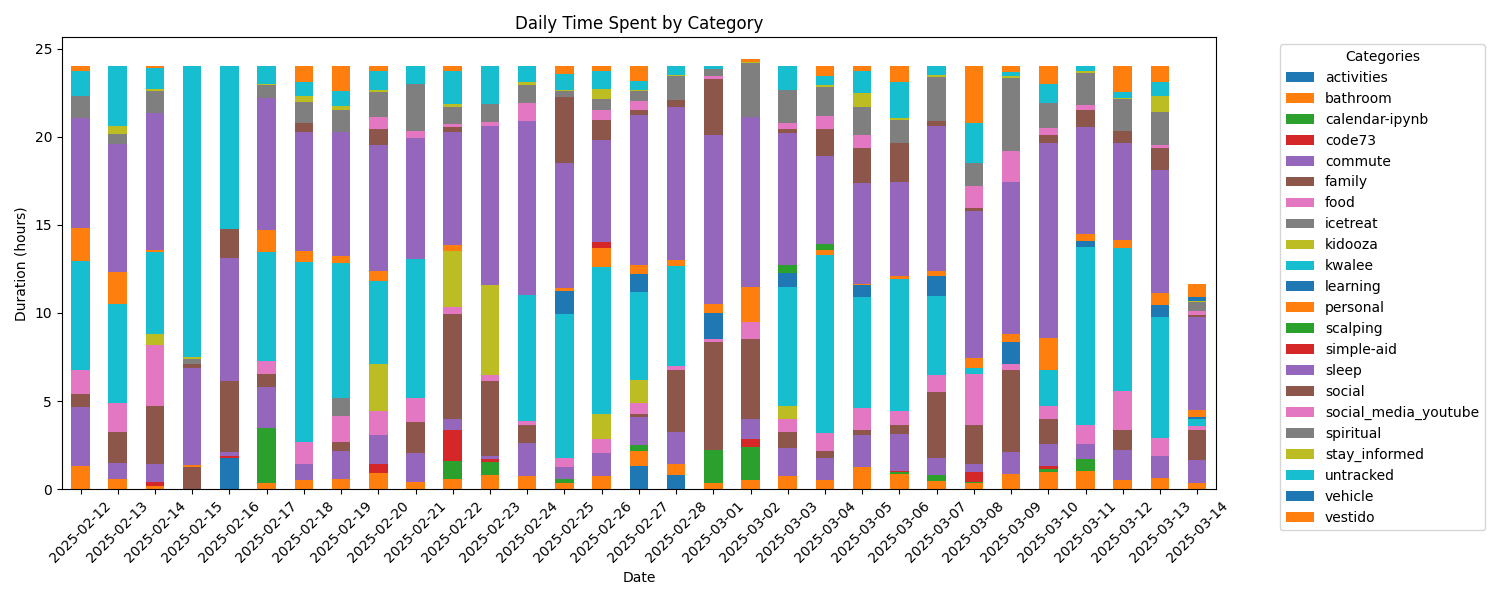

In [85]:
from calendar_ipynb.ipywidgets.bargraph_grouped_by_day import show_bargraph

show_bargraph(events)

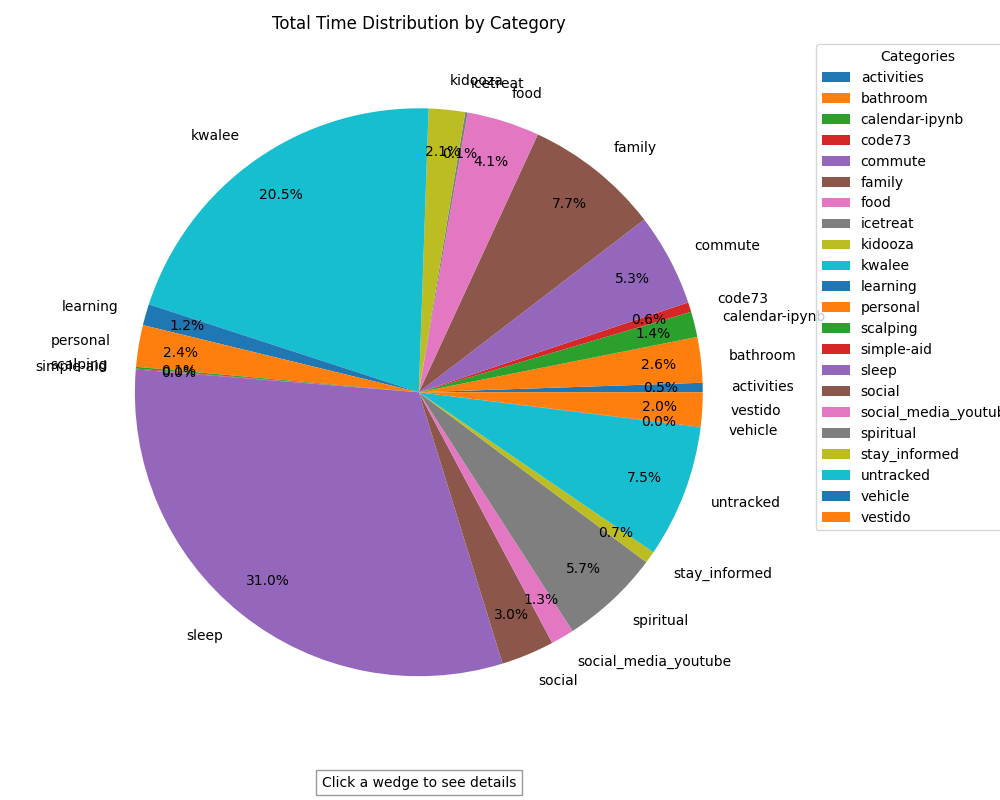

In [86]:
%matplotlib widget
from calendar_ipynb.ipywidgets.piechart import show_piechart

show_piechart(events)

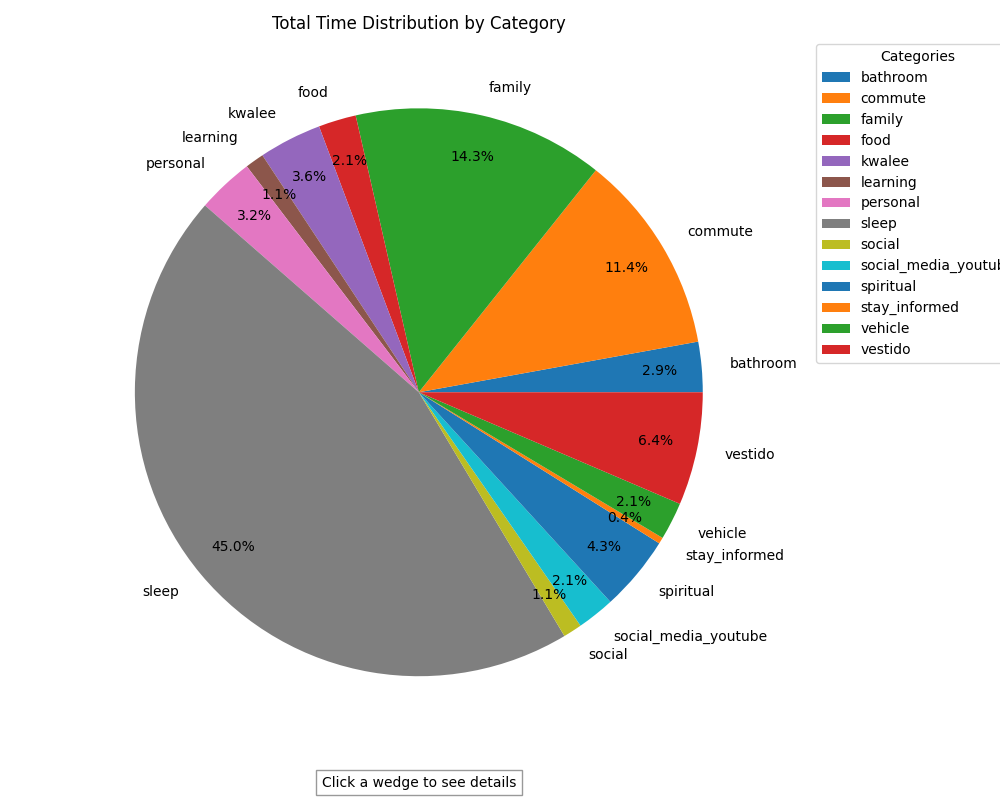

In [87]:
_today_events = [event for event in events if datetime.datetime.fromisoformat(event["start"]["dateTime"]).date() == datetime.date.today()]
show_piechart(_today_events)
